In [1]:
import fastf1
from fastf1 import plotting
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor


In [2]:
fastf1.Cache.enable_cache('f1_cache')  

In [3]:
session = fastf1.get_session(2024, 'Monza', 'R')
session.load()

core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']


In [4]:
laps = session.laps
laps = laps.pick_quicklaps()

driver_laps = laps[laps['Driver'] == 'LEC'].copy()
driver_laps.loc[:, 'LapTimeSeconds'] = driver_laps['LapTime'].dt.total_seconds()
driver_laps = driver_laps[['TyreLife', 'Compound', 'LapTimeSeconds']].dropna()

driver_laps.head(5)

,TyreLife,Compound,LapTimeSeconds
1,2.0,MEDIUM,85.396
2,3.0,MEDIUM,85.179
3,4.0,MEDIUM,84.810
4,5.0,MEDIUM,84.603
5,6.0,MEDIUM,84.663


In [13]:
top3_drivers = session.results[:3]['Abbreviation'].values.tolist()
print(top3_drivers)

['LEC', 'PIA', 'NOR']


In [14]:
all_laps = pd.DataFrame()

for driver in top3_drivers:
    driver_laps = laps.pick_drivers(driver).pick_quicklaps().copy()
    driver_laps['LapTimeSeconds'] = driver_laps['LapTime'].dt.total_seconds()
    driver_laps['Driver'] = driver
    all_laps = pd.concat([all_laps, driver_laps], ignore_index=True)

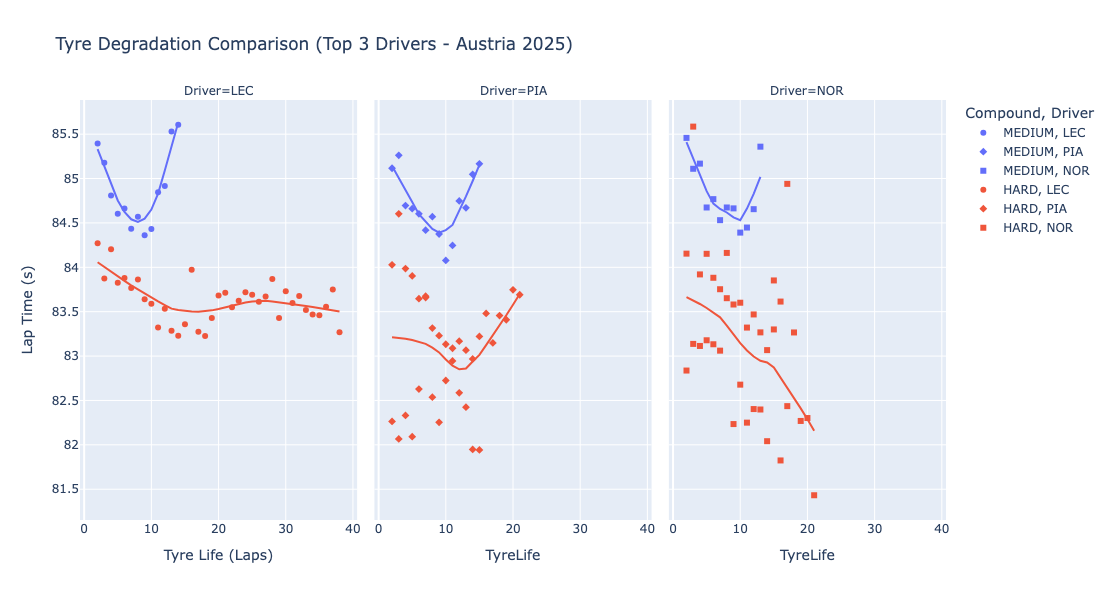

In [15]:
fig = px.scatter (all_laps,
    x='TyreLife',
    y='LapTimeSeconds',
    color='Compound',
    symbol='Driver', 
    facet_col='Driver', 
    trendline='lowess',
    hover_data=['LapNumber', 'Stint'],
    title='Tyre Degradation Comparison (Top 3 Drivers - Austria 2025)')

fig.update_layout(
    xaxis_title='Tyre Life (Laps)',
    yaxis_title='Lap Time (s)',
    height=600
)

fig.show()

In [5]:
print(driver_laps['Compound'].unique())

['MEDIUM' 'HARD']


In [6]:
X = driver_laps[['TyreLife', 'Compound']]
y = driver_laps['LapTimeSeconds']

preprocessor = ColumnTransformer (force_int_remainder_cols=False,
    transformers=[('comp', OneHotEncoder(), ['Compound'])],
    remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor), ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=8,        
        random_state=42
    ))
])

model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('comp', OneHotEncoder(),
                                                  ['Compound'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, random_state=42))])

In [7]:
def simulate_stint(start_lap, end_lap, compound, model):
    tyre_ages = list(range(end_lap - start_lap + 1))

    valid_compounds = driver_laps['Compound'].unique()
    if compound not in valid_compounds:
        raise ValueError(f"'{compound}' not found in training data. Use one of: {valid_compounds}")
        
    data = pd.DataFrame({
        'TyreLife': tyre_ages,
        'Compound': [compound] * len(tyre_ages)
    })
    predicted_laps = model.predict(data)
    return predicted_laps

In [8]:
def simulate_strategy(strategy, model, pit_loss=20.0):
    total_time = 0
    full_laps = []
    
    for i, stint in enumerate(strategy):
        stint_laps = simulate_stint(stint['start_lap'], stint['end_lap'], stint['compound'], model)
        full_laps.extend(stint_laps)
        total_time += np.sum(stint_laps)
        
        # Adding pit stop loss (except for last stint)
        if i < len(strategy) - 1:
            total_time += pit_loss

    return total_time, full_laps

In [9]:
strategy_1_stop = [
    {'compound': 'MEDIUM', 'start_lap': 1, 'end_lap': 15},
    {'compound': 'HARD', 'start_lap': 16, 'end_lap': 53}
]

strategy_2_stop = [
    {'compound': 'MEDIUM', 'start_lap': 1, 'end_lap': 17},
    {'compound': 'HARD', 'start_lap': 18, 'end_lap': 31},
    {'compound': 'MEDIUM', 'start_lap': 32, 'end_lap': 53}
]

total_time_1, laps_1 = simulate_strategy(strategy_1_stop, model)
total_time_2, laps_2 = simulate_strategy(strategy_2_stop, model)

In [10]:
from datetime import timedelta

def format_time(seconds):
    td = timedelta(seconds=seconds)
    total_seconds = int(td.total_seconds())
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    secs = total_seconds % 60
    millis = int((td.total_seconds() - total_seconds) * 1000)
    return f"{hours}:{minutes:02}:{secs:02}.{millis:03}"

print("1-Stop Strategy Time:", format_time(total_time_1))
print("2-Stop Strategy Time:", format_time(total_time_2))

1-Stop Strategy Time: 1:14:32.653
2-Stop Strategy Time: 1:15:29.714


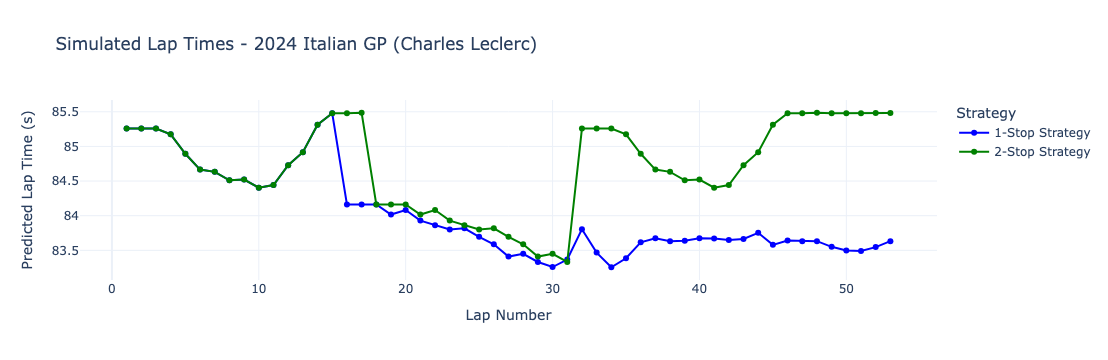

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=laps_1,
    x=list(range(1, len(laps_1) + 1)),
    mode='lines+markers',
    name='1-Stop Strategy',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    y=laps_2,
    x=list(range(1, len(laps_2) + 1)),
    mode='lines+markers',
    name='2-Stop Strategy',
    line=dict(color='green')
))

fig.update_layout(
    title="Simulated Lap Times - 2024 Italian GP (Charles Leclerc)",
    xaxis_title="Lap Number",
    yaxis_title="Predicted Lap Time (s)",
    legend_title="Strategy",
    template="plotly_white"
)

fig.show()

In [12]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.3f} seconds")

RMSE: 0.085 seconds
